# Q-learning with function approximation - allocentric environment

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/NiloufarRazmi/RL_Olfaction/HEAD?labpath=FuncApprox%2FFuncApprox_allo.ipynb)

## The task

<img src='./img/task.png' width="400">

## Initialization

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm
import pandas as pd
import re

In [2]:
# Load custom functions
from utils import Params
from environment_allo import (
    WrappedEnvironment,
    Actions,
    CONTEXTS_LABELS,
    LightCues,
    OdorID,
)
from agent import QLearningFuncApprox, EpsilonGreedy
import plotting
from plotting_ego import plot_location_count

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Choose the task parameters

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.1, n_runs=20, numEpisodes=300, alpha=0.025)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.025, jointRep=True, n_runs=30, numEpisodes=300)

## Load the environment and the agent algorithms

In [5]:
# Load the environment
env = WrappedEnvironment(params)

Manually engineered features, optional.
If `None`, a diagonal matrix of features will be created automatically

In [6]:
# features = np.matlib.repmat(
#     np.eye(len(env.tiles_locations), len(env.tiles_locations)),
#     len(env.cues),
#     len(env.cues),
# )
# features.shape

In [7]:
tmp1 = np.matlib.repmat(
    np.eye(len(env.tiles_locations), len(env.tiles_locations)), len(env.cues), 1
)
tmp1.shape

(100, 25)

In [8]:
tmp2 = np.vstack(
    (
        np.hstack(
            (
                np.ones((len(env.tiles_locations), 1)),
                np.zeros((len(env.tiles_locations), len(env.cues) - 1)),
            )
        ),
        np.hstack(
            (
                np.zeros((len(env.tiles_locations), 1)),
                np.ones((len(env.tiles_locations), 1)),
                np.zeros((len(env.tiles_locations), len(env.cues) - 2)),
            )
        ),
        np.hstack(
            (
                np.zeros((len(env.tiles_locations), 2)),
                np.ones((len(env.tiles_locations), 1)),
                np.zeros((len(env.tiles_locations), len(env.cues) - 3)),
            )
        ),
        np.hstack(
            (
                np.zeros((len(env.tiles_locations), len(env.cues) - 1)),
                np.ones((len(env.tiles_locations), 1)),
            )
        ),
    )
)

tmp2.shape

(100, 4)

In [9]:
tmp2 = np.vstack(
    (
        np.hstack(
            (
                np.ones((len(env.tiles_locations) * len(OdorID), 1)),
                np.zeros((len(env.tiles_locations) * len(OdorID), 1)),
            )
        ),
        np.hstack(
            (
                np.zeros((len(env.tiles_locations) * len(LightCues), 1)),
                np.ones((len(env.tiles_locations) * len(LightCues), 1)),
            )
        ),
    )
)

tmp2.shape

(100, 2)

In [10]:
features = np.hstack((tmp1, tmp2))
features.shape

(100, 27)

In [11]:
# features = None

In [12]:
# Load the agent algorithms
learner = QLearningFuncApprox(
    learning_rate=params.alpha,
    gamma=params.gamma,
    state_size=env.numStates,
    action_size=env.numActions,
    features_matrix=features,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

In [13]:
braces = []
for idx, cue in enumerate(CONTEXTS_LABELS):
    braces.append(
        {
            "p1": [-5, idx * len(env.tiles_locations)],
            "p2": [-5, (idx + 1) * len(env.tiles_locations)],
            "str_text": re.sub(r"^P.*?odor - ", "", CONTEXTS_LABELS[cue]),
        }
    )
braces

[{'p1': [-5, 0], 'p2': [-5, 25], 'str_text': 'North light'},
 {'p1': [-5, 25], 'p2': [-5, 50], 'str_text': 'South light'},
 {'p1': [-5, 50], 'p2': [-5, 75], 'str_text': 'Odor A'},
 {'p1': [-5, 75], 'p2': [-5, 100], 'str_text': 'Odor B'}]

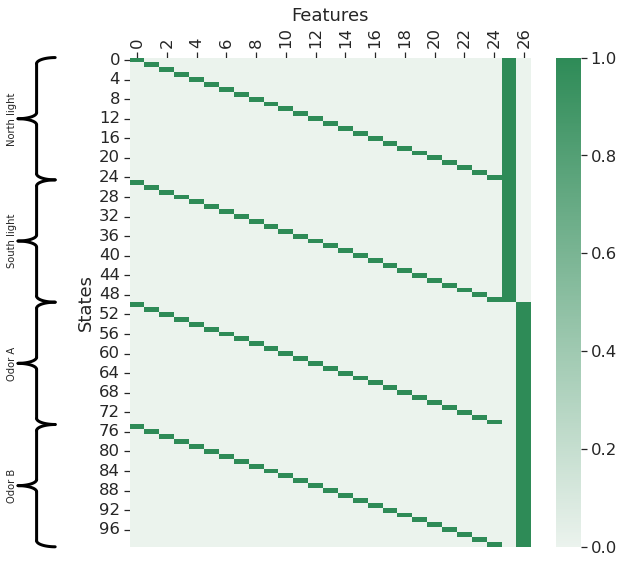

In [14]:
plotting.plot_heatmap(
    matrix=learner.features, title="Features", ylabel="States", braces=braces
)

In [15]:
learner.Q_hat_table.shape, learner.weights.shape, learner.features.shape

((100, 4), (27, 4), (100, 27))

## States and actions meaning

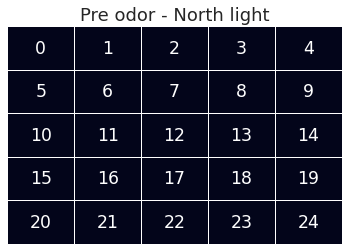

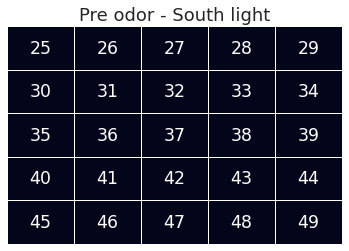

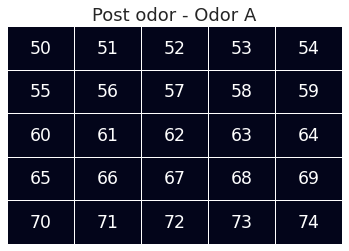

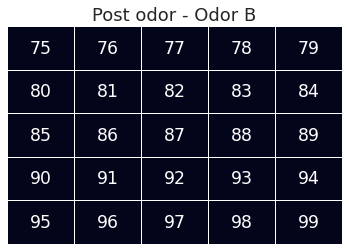

In [16]:
# State space
for idx, cue in enumerate(CONTEXTS_LABELS):
    plotting.plot_tiles_locations(
        np.array(list(env.tiles_locations)) + idx * len(env.tiles_locations),
        env.rows,
        env.cols,
        title=CONTEXTS_LABELS[cue],
    )

### Correspondance between flat states and (internal) composite states

In [17]:
state = 63
env.convert_flat_state_to_composite(state)

{'location': 13, 'cue': <OdorID.A: 1>}

In [18]:
env.convert_composite_to_flat_state({"location": 13, "cue": LightCues.North})

13

### Action meaning

In [19]:
action = 0
Actions(action)

<Actions.UP: 0>

## Main loop

In [20]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)
qtables = np.zeros((params.n_runs, *learner.Q_hat_table.shape))
all_states = []
all_actions = []

for run in range(params.n_runs):  # Run several times to account for stochasticity
    learner.reset(
        action_size=env.numActions
    )  # Reset the Q-table and the weights between runs

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            learner.Q_hat_table = learner.Q_hat(learner.weights, learner.features)

            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                qtable=learner.Q_hat_table,
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action).name)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.weights[:, action] = learner.update_weights(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
    qtables[run, :, :] = learner.Q_hat_table

## Postprocessing

In [21]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(order="F"),
        "Steps": steps.flatten(order="F"),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

In [22]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,0.0,124.0,0.0
1,1,0.0,43.0,0.0
2,2,0.0,189.0,0.0
3,3,0.0,72.0,0.0
4,4,0.0,117.0,0.0
...,...,...,...,...
8995,295,0.0,254.0,1380.0
8996,296,10.0,276.0,1390.0
8997,297,10.0,57.0,1400.0
8998,298,0.0,67.0,1400.0


In [23]:
tmp = []
for idx, st in enumerate(tqdm(all_states)):
    tmp.append(env.convert_flat_state_to_composite(st))
all_state_composite = pd.DataFrame(tmp)
all_state_composite

100%|█████████████████████████████████████████████████| 32588497/32588497 [00:58<00:00, 552889.04it/s]


,location,cue
0,23,LightCues.South
1,18,LightCues.South
2,19,LightCues.South
3,18,LightCues.South
4,23,LightCues.South
...,...,...
32588492,3,LightCues.North
32588493,4,OdorID.A
32588494,9,OdorID.A
32588495,14,OdorID.A


## Visualization

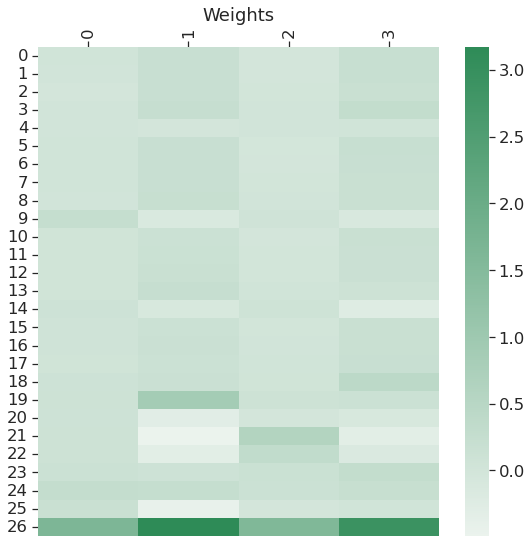

In [24]:
plotting.plot_heatmap(matrix=learner.weights, title="Weights")

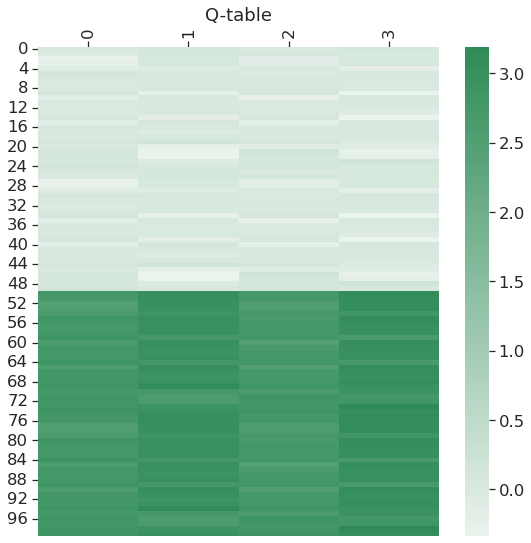

In [25]:
plotting.plot_heatmap(matrix=qtable, title="Q-table")

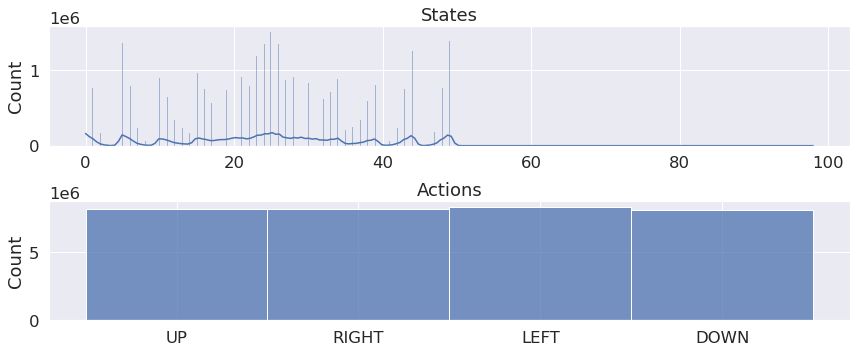

In [26]:
plotting.plot_states_actions_distribution(all_states, all_actions)

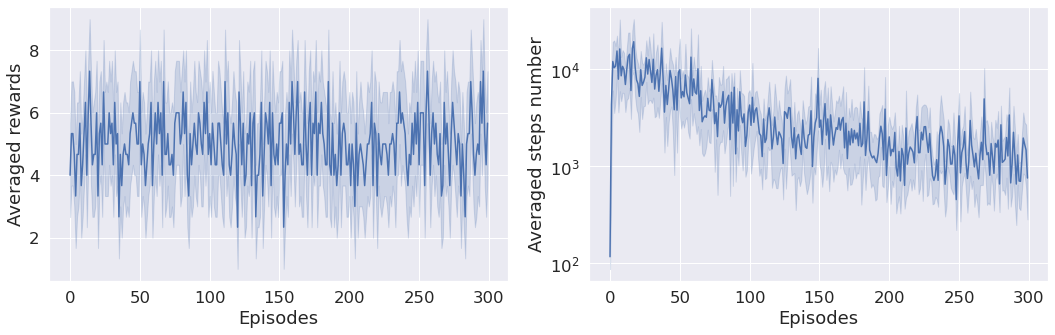

In [42]:
plotting.plot_steps_and_rewards(res, log=True)

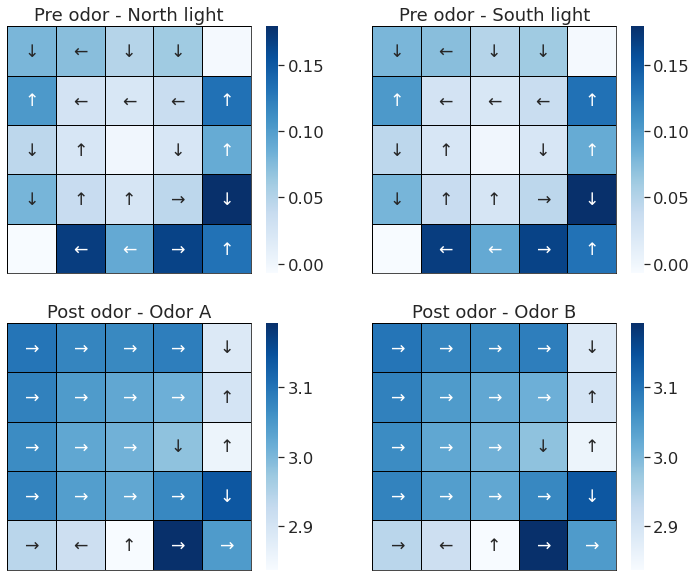

In [28]:
plotting.plot_q_values_maps(qtable, env.rows, env.cols, CONTEXTS_LABELS)

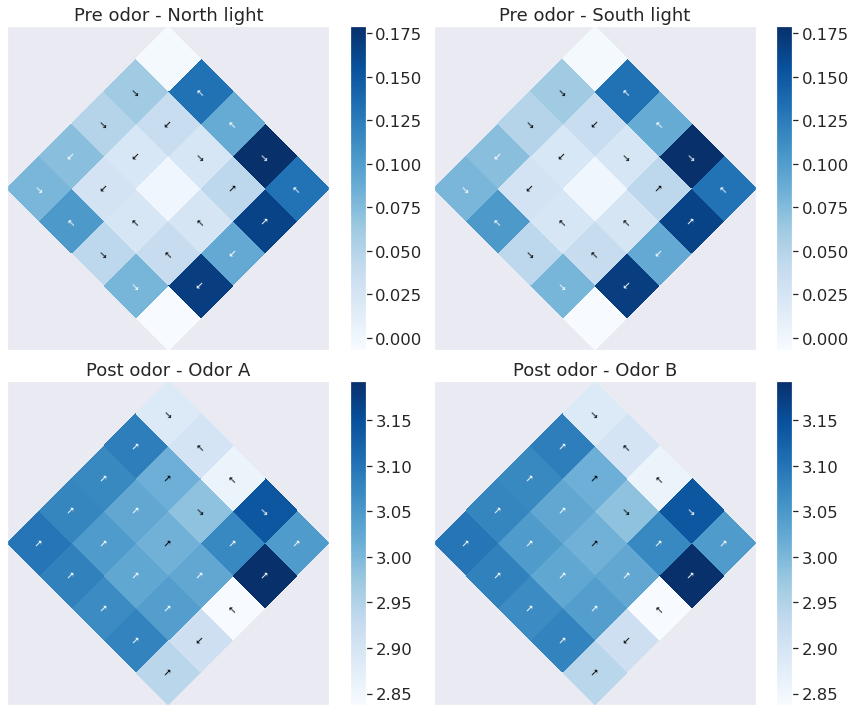

In [29]:
plotting.plot_rotated_q_values_maps(qtable, env.rows, env.cols, CONTEXTS_LABELS)

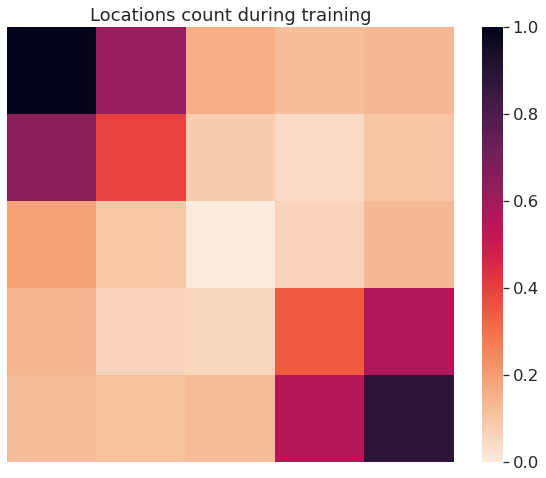

In [30]:
plot_location_count(
    all_state_composite,
    tiles_locations=env.tiles_locations,
    cols=env.cols,
    rows=env.rows,
    cues=None,
    contexts_labels=None,
)

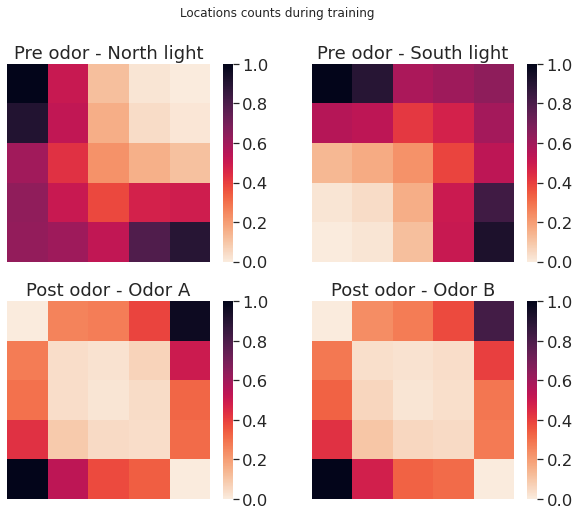

In [31]:
plot_location_count(
    all_state_composite,
    tiles_locations=env.tiles_locations,
    cols=env.cols,
    rows=env.rows,
    cues=env.cues,
    contexts_labels=CONTEXTS_LABELS,
)

## Presentations figures

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2)

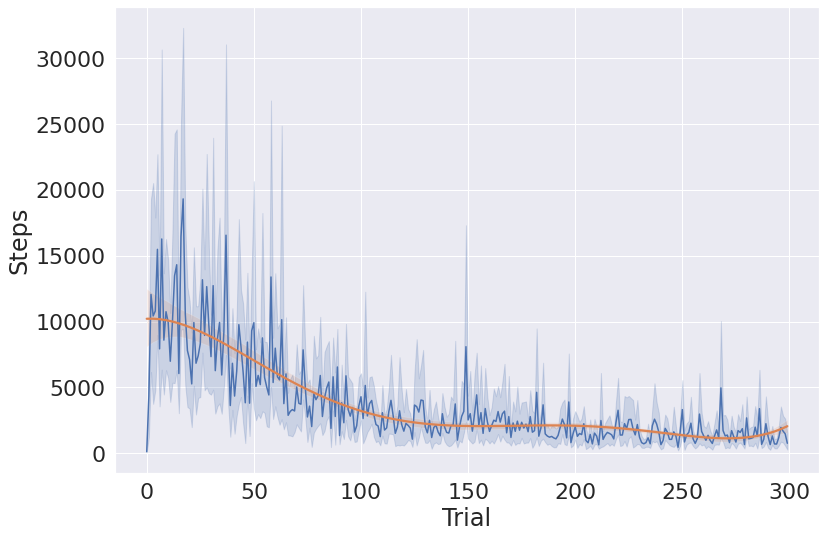

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=res, x="Episodes", y="Steps", ax=ax)
sns.regplot(
    x="Episodes",
    y="Steps",
    data=res,
    ax=ax,
    order=5,
    scatter=False,
    # ci=None,
    # scatter_kws={"s": 80},
    line_kws={"color": "C1"},
)
ax.set(xlabel="Trial")
fig.tight_layout()
fig.patch.set_alpha(0)
fig.patch.set_facecolor("white")
plt.show()

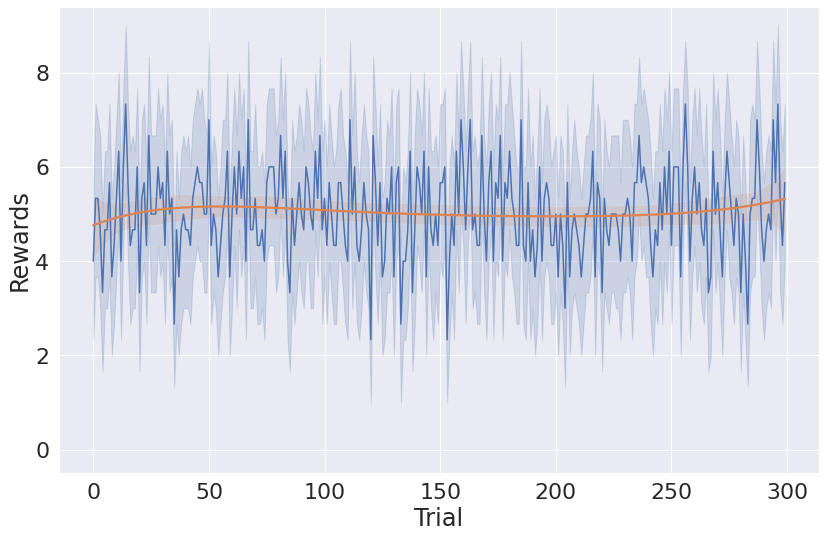

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=res, x="Episodes", y="Rewards", ax=ax)
sns.regplot(
    x="Episodes",
    y="Rewards",
    data=res,
    ax=ax,
    order=6,
    # ci=None,
    # scatter_kws={"s": 80},
    scatter=False,
    line_kws={"color": "C1"},
)
ax.set_ylim(bottom=-0.5)
fig.tight_layout()
fig.patch.set_alpha(0)
fig.patch.set_facecolor("white")
ax.set(xlabel="Trial")
plt.show()

In [35]:
emoji = [
    [{"emoji": "💡", "coords": [4.5, 0.5]}],
    [{"emoji": "💡", "coords": [0.5, 4.5]}],
    [{"emoji": "💧", "coords": [0.5, 0.5]}, {"emoji": "🍌", "coords": [4, -0.25]}],
    [{"emoji": "💧", "coords": [4.5, 4.5]}, {"emoji": "🍋", "coords": [4, -0.25]}],
]

In [36]:
from collections import OrderedDict

trunc_labels = OrderedDict(
    [
        (LightCues.North, "Pre odor - North light"),
        (LightCues.South, "Pre odor - South light"),
        (OdorID.A, "Post odor - "),
        (OdorID.B, "Post odor - "),
    ]
)

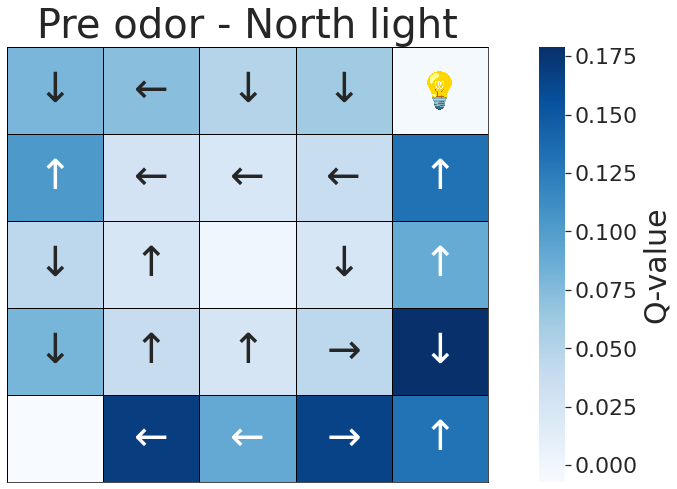

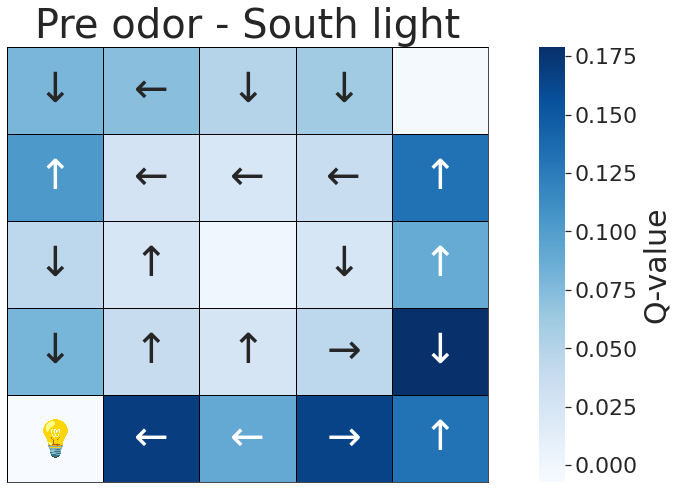

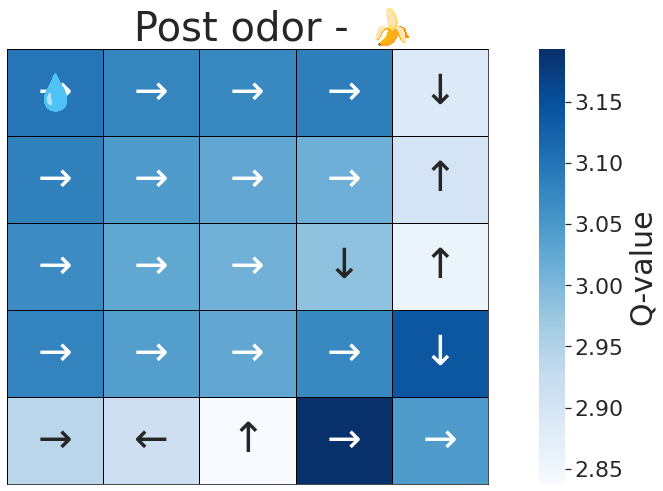

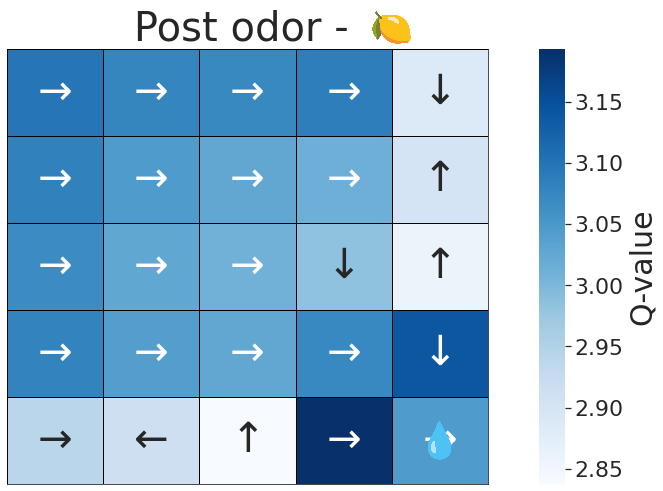

In [37]:
for idx, cue in enumerate(trunc_labels):
    current_map = np.array(list(env.tiles_locations)) + idx * len(env.tiles_locations)
    current_q_table = qtable[current_map, :]
    plotting.plot_policy_emoji(
        qtable=current_q_table,
        rows=env.rows,
        cols=env.cols,
        label=trunc_labels[cue],
        emoji=emoji[idx],
    )

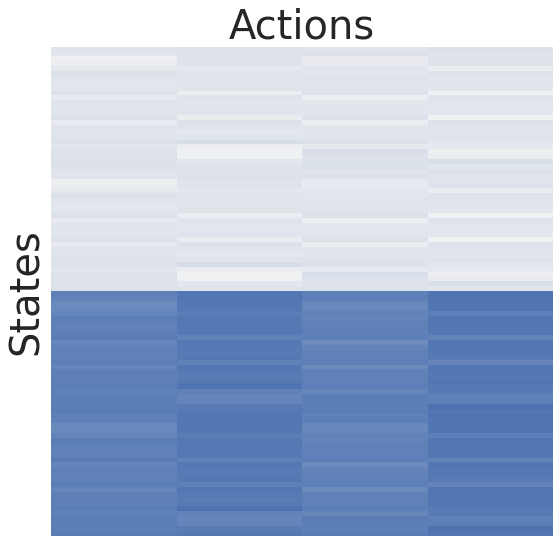

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(9, 9))
# cmap = sns.light_palette("seagreen", as_cmap=True)
cmap = sns.color_palette("light:b", as_cmap=True)
chart = sns.heatmap(qtable, cmap=cmap, ax=ax, cbar=False)
chart.set_title("Actions", fontsize=40)
chart.set_ylabel("States", fontsize=40)
ax.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
fig.patch.set_alpha(0)
fig.patch.set_facecolor("white")
plt.show()

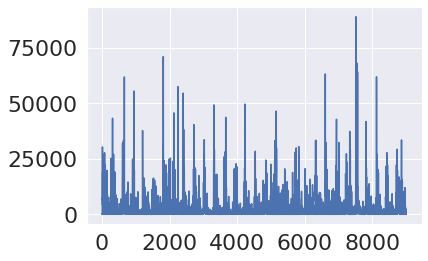

In [39]:
plt.plot(res.Steps.rolling(window=3).mean())

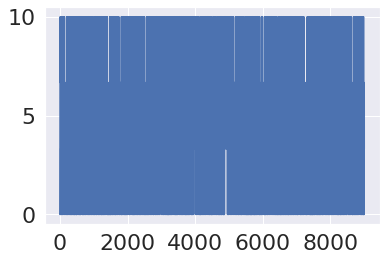

In [40]:
plt.plot(res.Rewards.rolling(window=3).mean())